In [59]:
import os
from os.path import join
import cv2
from scipy.interpolate import splprep, splev
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rich.progress import track

sns.set(color_codes=True, style="white")
pd.options.mode.chained_assignment = None  # default='warn'

labels = [
    # "0 h", # removed due to small dataset size and fuzzy distribution
    "8 h",
    "24 h",
]

color1 = "#f7a863"
color2 = "#d25743"
color3 = "#2b3744"
palette = [
    # color1,
    color2,
    color3,
]

folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/paper_figure_plots/post_bioRxiv_Figs/Morphology-aging"


# For first time calculation only
folder_data = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/all_SPT_in_condensates/Reconstruction_20ms-FUS488_10kframes-aging"
folders = [
    # "contours_0h",
    "contours_8h",
    "contours_24h",
]

## Calculate and save

In [60]:
def smooth_contour(contour):
    # Extract x and y coordinates
    x, y = contour[:, 0, 0], contour[:, 0, 1]

    # Fit a spline to the contour points
    tck, u = splprep([x, y], s=1.0, per=1)

    # Generate new points along the spline
    u_new = np.linspace(u.min(), u.max(), 25)
    x_new, y_new = splev(u_new, tck, der=0)

    # Convert back to contour format
    return np.array([[int(x), int(y)] for x, y in zip(x_new, y_new)], dtype=np.int32).reshape(-1, 1, 2)

def calculate_circularity(contour):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        return 0
    circularity = 4 * math.pi * (area / (perimeter * perimeter))
    return circularity


os.chdir(folder_data)
lst_rows = []
for label, folder in zip(labels, folders):  # loop each condition
    lst_fname = [f for f in os.listdir(join(folder_data, folder)) if f.endswith(".p")]
    for fname in track(lst_fname, description=folder):
        with open(join(folder_data, folder, fname), "rb") as file:
            contour = pickle.load(file)
        smoothed_contour = smooth_contour(contour)
        circularity = calculate_circularity(smoothed_contour)
        lst_rows.append([label, fname, circularity])
df_raw = pd.DataFrame(
    lst_rows,
    columns=["label", "fname", "circularity"],
    dtype=object,
)
df_raw = df_raw.astype(
    {
        "label": str,
        "fname": str,
        "circularity": float,
    }
)
df_raw.to_csv(
    join(folder_save, "circularity_per_condition_per_condensate.csv"),
    index=False,
)

Output()

Output()

# Circularity distribution

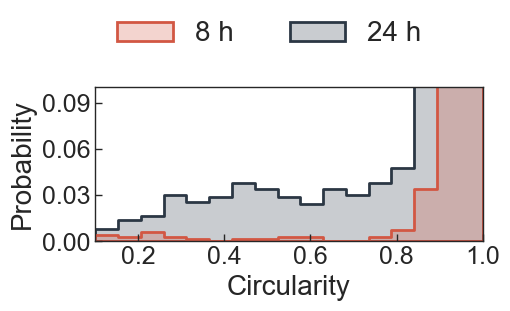

In [75]:
fontsize = 20
plt.figure(figsize=(5, 2))
bins = 17
ax = sns.histplot(
    data=df_raw,
    x="circularity",
    hue="label",
    palette=palette,
    bins=bins,
    stat="probability",
    common_norm=False,
    binrange=(0.1, 1),
    lw=2,
    element="step",
    # fill=False,
    # cumulative=True,
    # legend=False,
)
sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(0.45, 1.1),
    ncol=3,
    title=None,
    frameon=False,
    fontsize=fontsize,
)
plt.xlim(0.1, 1)
# plt.xticks([0, 90, 180])
plt.ylim(0, 0.1)
plt.yticks([0, 0.03, 0.06, 0.09])
plt.xlabel("Circularity", fontsize=fontsize)
plt.ylabel("Probability", fontsize=fontsize)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=fontsize,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig("circularity_histo.png", format="png", bbox_inches="tight", dpi=600)

In [ ]:
#